# Semantic Text Similarity - Práctica 4
## Entrenamiento y evaluación de modelos de Similitud de Texto Semántico (STS) para catalán

### Objetivos:
1. **Preparación de Embeddings**: Reducción de dimensiones (50, 100, 150, 300)
2. **Representación de frases**: Media simple y TF-IDF
3. **Baseline Coseno**: Sin entrenamiento
4. **Modelos de Regresión**: Embeddings agregados y secuencias
5. **Experimentación**: Embeddings entrenables
6. **Análisis de resultados**: Comparación de rendimiento

## 1. Configuración inicial e imports

In [ ]:
%pip uninstall -y tensorflow tensorflow-estimator keras keras-preprocessing protobuf

%pip install tensorflow==2.14 protobuf==3.20.*


In [47]:
%pip list

Note: you may need to restart the kernel to use updated packages.Package                      Version
---------------------------- --------------
absl-py                      2.3.0
aiohappyeyeballs             2.6.1
aiohttp                      3.12.4
aiosignal                    1.3.2
annotated-types              0.7.0
anyio                        4.9.0
argon2-cffi                  25.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
async-timeout                5.0.1
attrs                        25.3.0
babel                        2.17.0
beautifulsoup4               4.13.4
bleach                       6.2.0
blis                         1.3.0
ca_core_news_trf             3.8.0
cachetools                   5.5.2
catalogue                    2.0.10
certifi                      2025.4.26
cffi                         1.17.1
charset-normalizer           3.4.2
cl


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Requisitos
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from typing import Tuple, List, Optional, Union
from scipy.stats import pearsonr
from scipy import spatial
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import gensim
import warnings
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

c:\Users\34644\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuración y funciones de preprocesamiento

In [2]:
# ========================================================
# CONFIGURACIÓN INICIAL
# ========================================================

# Configuraciones del modelo
USE_PRETRAINED = True
REMAP_EMBEDDINGS = True
SEQUENCE_LENGTH = 32

# Cargar stopwords en Catalan (ampliado)
STOPWORDS_CA = {
    "a", "al", "el", "la", "els", "les", "de", "un", "una", "algun", "alguna",
    "i", "o", "per", "amb", "en", "del", "dels", "d", "l", "t", "s", "és", "són",
    "que", "com", "més", "tot", "amb", "però", "si", "no", "ja", "també"
}

def preprocess(sentence: str) -> List[str]:
    """Función mejorada de preprocesamiento"""
    preprocessed = simple_preprocess(sentence, min_len=2)  # Mínimo 2 caracteres
    preprocessed = [token for token in preprocessed if token not in STOPWORDS_CA]
    return preprocessed

print("Configuración completada")

Configuración completada


## 3. Carga del modelo Fasttext

In [6]:
# Cargar modelo Word2Vec
WV_MODEL_PATH = './cc.ca.300.vec/cc.ca.300.vec'
wv_model = gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)


## 4. Preparación de embeddings - Reducción de dimensiones

In [7]:
def reduir_dimensionalitat_embeddings(wv_model, dim_target, metode):
        
    vocab = list(wv_model.key_to_index.keys())
    all_embeddings = wv_model.vectors  # shape: (vocab_size, embedding_dim)
    dim_original = all_embeddings.shape[1]
    
    if dim_target >= dim_original:
        warnings.warn(f"La dimensió objectiu ({dim_target}) és >= que l'original ({dim_original}). Retornant model original.")
        return wv_model
    
    # Aplicar el mètode de reducció escollit
    if metode == 'truncament':
        # Truncament simple: agafar les primeres N dimensions
        embeddings_reduits = all_embeddings[:, :dim_target]
        
    elif metode == 'projections':
        # Projeccions aleatòries amb Gaussian Random Projection
        transformer = GaussianRandomProjection(n_components=dim_target, random_state=42)
        embeddings_reduits = transformer.fit_transform(all_embeddings)
        
    elif metode == 'variancia':
        # Selecció de dimensions amb més variància
        variances = np.var(all_embeddings, axis=0)
        top_indices = np.argsort(variances)[::-1][:dim_target]
        embeddings_reduits = all_embeddings[:, top_indices]
        
    elif metode == 'pca':
        # Anàlisi de Components Principals
        pca = PCA(n_components=dim_target, random_state=42)
        embeddings_reduits = pca.fit_transform(all_embeddings)
        
    elif metode == 'blocs':
        # Agregació de blocs (chunk averaging)
        if dim_original % dim_target != 0:
            # Ajustar per a que sigui divisible
            chunk_size = dim_original // dim_target
            dim_used = chunk_size * dim_target
            embeddings_truncated = all_embeddings[:, :dim_used]
        else:
            chunk_size = dim_original // dim_target
            embeddings_truncated = all_embeddings
            
        # Reshape i calcular mitjana per blocs
        reshaped = embeddings_truncated.reshape(len(vocab), dim_target, chunk_size)
        embeddings_reduits = np.mean(reshaped, axis=2)
        
    else:
        raise ValueError(f"Mètode '{metode}' no reconegut. Utilitza: 'truncament', 'projections', 'variancia', 'pca', 'blocs'")
    
    # Crear nou model KeyedVectors amb els embeddings reduïts
    nou_model = gensim.models.KeyedVectors(vector_size=dim_target)
    nou_model.add_vectors(vocab, embeddings_reduits)
    
    return nou_model

dimensions = [50, 100, 150]
metodes = ['truncament','projections', 'variancia', 'pca', 'blocs']
all_models = {300: wv_model}

for dim in dimensions:
    for metode in metodes:
        key = f"{dim}d_{metode}"
        print(f"Processant {key}...")
        all_models[key] = reduir_dimensionalitat_embeddings(wv_model, dim, metode) 


print(f"Models -> {list(all_models.keys())}")


Processant 50d_truncament...
Processant 50d_projections...
Processant 50d_variancia...
Processant 50d_pca...
Processant 50d_blocs...
Processant 100d_truncament...
Processant 100d_projections...
Processant 100d_variancia...
Processant 100d_pca...
Processant 100d_blocs...
Processant 150d_truncament...
Processant 150d_projections...
Processant 150d_variancia...
Processant 150d_pca...
Processant 150d_blocs...
Models -> [300, '50d_truncament', '50d_projections', '50d_variancia', '50d_pca', '50d_blocs', '100d_truncament', '100d_projections', '100d_variancia', '100d_pca', '100d_blocs', '150d_truncament', '150d_projections', '150d_variancia', '150d_pca', '150d_blocs']


## 5. Carga y preprocesamiento del dataset

In [8]:
# ========================================================
# CARGA Y PREPROCESAMIENTO DE DATOS
# ========================================================

# Cargar dataset
print("Cargando dataset STS-ca...")
train = load_dataset("projecte-aina/sts-ca", split="train")
test = load_dataset("projecte-aina/sts-ca", split="test")
val = load_dataset("projecte-aina/sts-ca", split="validation")
all_data = load_dataset("projecte-aina/sts-ca", split="all")

print(f"Datos cargados: {len(all_data)} pares de oraciones")
print(f"Train: {len(train)}, Test: {len(test)}, Val: {len(val)}")

# Preprocesamiento del split de entrenamiento
train_sent_1 = [simple_preprocess(d["sentence_1"]) for d in train]
train_sent_2 = [simple_preprocess(d["sentence_2"]) for d in train]
train_labels = [d["label"] for d in train]
train_pairs = list(zip(train_sent_1, train_sent_2, train_labels))
train_flat = train_sent_1 + train_sent_2

# Crear diccionario y modelo TF-IDF solo con datos de entrenamiento
diccionario = Dictionary(train_flat)
corpus = [diccionario.doc2bow(sent) for sent in train_flat]
modelo_tfidf = TfidfModel(corpus)

# Per al baseline cosinus, com no necesitem entrenament, podem utilitzar all_data i comparar els resultats

# Preprocesamiento del split de validación
val_sent_1 = [simple_preprocess(d["sentence_1"]) for d in val]
val_sent_2 = [simple_preprocess(d["sentence_2"]) for d in val]
val_labels = [d["label"] for d in val]
val_pairs = list(zip(val_sent_1, val_sent_2, val_labels))

# Preprocesamiento del split de test
test_sent_1 = [simple_preprocess(d["sentence_1"]) for d in test]
test_sent_2 = [simple_preprocess(d["sentence_2"]) for d in test]
test_labels = [d["label"] for d in test]
test_pairs = list(zip(test_sent_1, test_sent_2, test_labels))


Cargando dataset STS-ca...
Datos cargados: 3073 pares de oraciones
Train: 2073, Test: 500, Val: 500


Dimensions:
Train: (2073, 4)
Test: (500, 4)
Validation: (500, 4)

Mostra de dades:


,id,sentence_1,sentence_2,label
0,ACN2_111,Atorga per primer cop les mencions Encarna San...,Creen la menció M. Encarna Sanahuja a la inclu...,3.50
1,Oscar2_211,"Finalment, afegiu-hi els bolets que haureu sal...","Finalment, poseu-hi les minipastanagues tallad...",1.25
2,ACN2_574,El TC suspèn el pla d'acció exterior i de rela...,El Constitucional manté la suspensió del pla e...,3.67
3,Viqui2_341,Virgin Galactic va ser fundada el 2004 per l'e...,Virgin Atlantic és una de les aerolínies de Ri...,2.25
4,ACN2_1184,Identifiquen un nou biomarcador per realitzar ...,Nous tractaments contra el càncer de mama,2.00



Columnes:
Index(['id', 'sentence_1', 'sentence_2', 'label'], dtype='object')

Tipus de dades:
id             object
sentence_1     object
sentence_2     object
label         float64
dtype: object

Valors nuls per columna:
id            0
sentence_1    0
sentence_2    0
label         0
dtype: int64


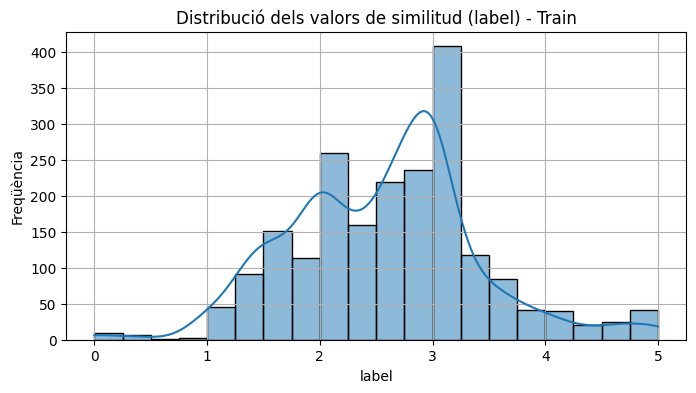


Exemples:
Frase 1: Atorga per primer cop les mencions Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència Universitària
Frase 2: Creen la menció M. Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència universitària
label: 3.5
---
Frase 1: Finalment, afegiu-hi els bolets que haureu saltat en una paella amb oli i deixeu-ho coure tot junt durant 5 minuts.
Frase 2: Finalment, poseu-hi les minipastanagues tallades a dauets, els pèsols, rectifiqueu-ho de sal i deixeu-ho coure tot junt durant un parell de minuts més.
label: 1.25
---
Frase 1: El TC suspèn el pla d'acció exterior i de relacions amb la UE de la Generalitat
Frase 2: El Constitucional manté la suspensió del pla estratègic d'acció exterior i relacions amb la UE
label: 3.67
---


In [9]:
# Convertir a DataFrame per facilitar l'anàlisi
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
val_df = pd.DataFrame(val)

# Dimensions dels datasets
print("Dimensions:")
print("Train:", train_df.shape)
print("Test:", test_df.shape)
print("Validation:", val_df.shape)

# Mostrar les primeres files
print("\nMostra de dades:")
display(train_df.head())

# Columnes del dataset
print("\nColumnes:")
print(train_df.columns)

# Tipus de dades
print("\nTipus de dades:")
print(train_df.dtypes)

# Comprovació de valors nuls
print("\nValors nuls per columna:")
print(train_df.isnull().sum())

# Distribució dels valors de similitud
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
sns.histplot(train_df["label"], bins=20, kde=True)
plt.title("Distribució dels valors de similitud (label) - Train")
plt.xlabel("label")
plt.ylabel("Freqüència")
plt.grid(True)
plt.show()

# Exemple de parells de frases amb el seu label
print("\nExemples:")
for i in range(3):
    print(f"Frase 1: {train_df['sentence_1'][i]}")
    print(f"Frase 2: {train_df['sentence_2'][i]}")
    print(f"label: {train_df['label'][i]}")
    print("---")


## 6. Funciones de representación de frases

In [10]:
# ========================================================
# FUNCIONES DE REPRESENTACIÓN DE FRASES
# ========================================================

def map_tf_idf(sentence_preproc: List[str], dictionary: Dictionary, tf_idf_model: TfidfModel, embedding_model=None) -> Tuple[List[np.ndarray], List[float]]:
    """Mapea palabras a vectores usando pesos TF-IDF"""
    model_to_use = embedding_model if embedding_model is not None else wv_model
    
    bow = dictionary.doc2bow(sentence_preproc)
    tf_idf = tf_idf_model[bow]
    vectors, weights = [], []
    
    for word_index, weight in tf_idf:
        word = dictionary.get(word_index)
        if word in model_to_use:
            vectors.append(model_to_use[word])
            weights.append(weight)
    
    return vectors, weights

def map_pairs_aggregated(
    sentence_pairs: List[Tuple[str, str, float]],
    dictionary: Dictionary = None,
    tf_idf_model: TfidfModel = None,
    embedding_model=None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Función para mapear pares de oraciones a vectores agregados (para modelos 1)
    """
    model_to_use = embedding_model if embedding_model is not None else wv_model
    pares_vectores = []
    
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        sentence_1_preproc = preprocess(sentence_1) if isinstance(sentence_1, str) else sentence_1
        sentence_2_preproc = preprocess(sentence_2) if isinstance(sentence_2, str) else sentence_2
        
        # Usar TF-IDF si está disponible
        if tf_idf_model is not None:
            vectors1, weights1 = map_tf_idf(sentence_1_preproc, dictionary=dictionary, 
                                          tf_idf_model=tf_idf_model, embedding_model=model_to_use)
            vectors2, weights2 = map_tf_idf(sentence_2_preproc, dictionary=dictionary, 
                                          tf_idf_model=tf_idf_model, embedding_model=model_to_use)
            
            if len(vectors1) == 0 or len(vectors2) == 0:
                # Vector de ceros si no hay vectores válidos
                vector1 = np.zeros(model_to_use.vector_size)
                vector2 = np.zeros(model_to_use.vector_size)
            else:
                vector1 = np.average(vectors1, weights=weights1, axis=0)
                vector2 = np.average(vectors2, weights=weights2, axis=0)
        else:
            # Media simple sin TF-IDF
            vectors1 = [model_to_use[word] for word in sentence_1_preproc if word in model_to_use]
            vectors2 = [model_to_use[word] for word in sentence_2_preproc if word in model_to_use]
            
            if len(vectors1) == 0 or len(vectors2) == 0:
                vector1 = np.zeros(model_to_use.vector_size)
                vector2 = np.zeros(model_to_use.vector_size)
            else:
                vector1 = np.mean(vectors1, axis=0)
                vector2 = np.mean(vectors2, axis=0)
        
        pares_vectores.append(((vector1, vector2), similitud))
    
    return pares_vectores

# ========================================================
# FUNCIONES PARA MODELO DE SECUENCIAS
# ========================================================

def map_word_embeddings(
        sentence: Union[str, List[str]],
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> np.ndarray:
    """
    Map to word-embedding indices
    """
    if not isinstance(sentence, list):
        sentence_preproc = simple_preprocess(sentence)
    else:
        sentence_preproc = sentence
    _vectors = np.zeros(sequence_len, dtype=np.int32)
    index = 0
    for word in sentence_preproc:
        if index >= sequence_len:  # Evitar desbordamiento
            break
        if fixed_dictionary is not None:
            if word in fixed_dictionary.token2id:
                # Sumo 1 porque el valor 0 está reservado a padding
                _vectors[index] = fixed_dictionary.token2id[word] + 1
                index += 1
        else:
            if word in wv_model.key_to_index:
                _vectors[index] = wv_model.key_to_index[word] + 1
                index += 1
    return _vectors

def map_pairs_sequences(
        sentence_pairs: List[Tuple[str, str, float]],
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de secuencias de índices (para modelo 2)
    """
    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        vector1 = map_word_embeddings(sentence_1, sequence_len, fixed_dictionary)
        vector2 = map_word_embeddings(sentence_2, sequence_len, fixed_dictionary)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

print("Funciones de mapeo definidas")

Funciones de mapeo definidas


## 7. Baseline Coseno

In [71]:
# ========================================================
# BASELINE COSENO
# ========================================================

def cosine_baseline_evaluation(pairs, tf_idf_weighted=False):
    """Evaluación del baseline coseno sin entrenamiento"""
    true_scores = []
    predicted_scores = []
    
    for (vec1, vec2), score in pairs:
        # Normalizar los vectores
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        
        if norm1 > 0 and norm2 > 0:
            vec1_norm = vec1 / norm1
            vec2_norm = vec2 / norm2
            cosine_similarity = np.dot(vec1_norm, vec2_norm)
        else:
            cosine_similarity = 0
        
        # Escalar de [-1, 1] a [0, 5]
        predicted_score = 2.5 * (1.0 + cosine_similarity)
        
        true_scores.append(score)
        predicted_scores.append(predicted_score)
    
    # Calcular correlación de Pearson
    pearson_corr, p_value = pearsonr(true_scores, predicted_scores)
    
    print(f"Baseline Coseno {'con TF-IDF' if tf_idf_weighted else 'sin TF-IDF'}")
    print(f"Correlación de Pearson: {pearson_corr:.4f} (p-valor: {p_value:.4f})")
    
    return pearson_corr, true_scores, predicted_scores

# Evaluar baselines para todas las dimensiones
print("\n=== EVALUACIÓN DE BASELINES ===")
baseline_results = {}

for dim, embedding_model in all_models.items():
    print(f"\n--- DIMENSIÓN: {dim} ---")
    
    # Mapear pares con diferentes representaciones
    pairs_simple = map_pairs_aggregated(val_pairs, dictionary=None, tf_idf_model=None, embedding_model=embedding_model)
    pairs_tfidf = map_pairs_aggregated(val_pairs, dictionary=diccionario, tf_idf_model=modelo_tfidf, embedding_model=embedding_model)
    
    # Evaluar baselines y guardar todos los resultados
    simple_corr, simple_true, simple_pred = cosine_baseline_evaluation(pairs_simple)
    tfidf_corr, tfidf_true, tfidf_pred = cosine_baseline_evaluation(pairs_tfidf, tf_idf_weighted=True)
    
    baseline_results[dim] = {
        'simple': {
            'correlation': simple_corr,
            'true_scores': simple_true,
            'predicted_scores': simple_pred
        },
        'tfidf': {
            'correlation': tfidf_corr,
            'true_scores': tfidf_true,
            'predicted_scores': tfidf_pred
        }
    }


=== EVALUACIÓN DE BASELINES ===

--- DIMENSIÓN: 300 ---
Baseline Coseno sin TF-IDF
Correlación de Pearson: 0.2436 (p-valor: 0.0000)
Baseline Coseno con TF-IDF
Correlación de Pearson: 0.3406 (p-valor: 0.0000)

--- DIMENSIÓN: 50d_truncament ---
Baseline Coseno sin TF-IDF
Correlación de Pearson: 0.1752 (p-valor: 0.0001)
Baseline Coseno con TF-IDF
Correlación de Pearson: 0.3193 (p-valor: 0.0000)

--- DIMENSIÓN: 50d_projections ---
Baseline Coseno sin TF-IDF
Correlación de Pearson: 0.2201 (p-valor: 0.0000)
Baseline Coseno con TF-IDF
Correlación de Pearson: 0.3186 (p-valor: 0.0000)

--- DIMENSIÓN: 50d_variancia ---
Baseline Coseno sin TF-IDF
Correlación de Pearson: 0.1879 (p-valor: 0.0000)
Baseline Coseno con TF-IDF
Correlación de Pearson: 0.2582 (p-valor: 0.0000)

--- DIMENSIÓN: 50d_pca ---
Baseline Coseno sin TF-IDF
Correlación de Pearson: 0.2046 (p-valor: 0.0000)
Baseline Coseno con TF-IDF
Correlación de Pearson: 0.2926 (p-valor: 0.0000)

--- DIMENSIÓN: 50d_blocs ---
Baseline Coseno sin 

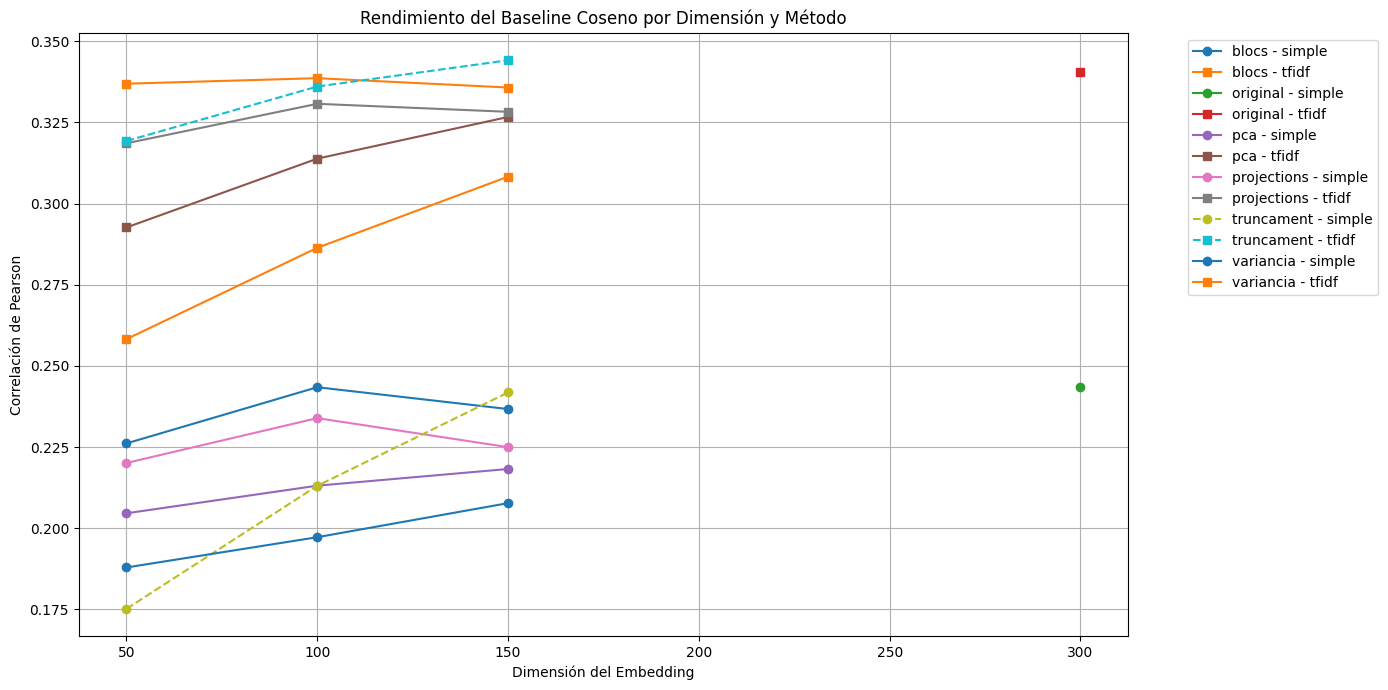

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gráfico de correlaciones por dimensión y método
results_by_method = {}

for model_name, values in baseline_results.items():
    # Procesar el nombre del modelo para extraer dimensión y método
    if isinstance(model_name, int):
        # Caso simple: 300 (int)
        dim = model_name
        method = 'original'
    else:
        # Caso complejo: '50d_truncament'
        try:
            dim_str, method = model_name.split('d_')
            dim = int(dim_str)
        except Exception as e:
            print(f"Error procesando el nombre del modelo '{model_name}': {e}")
            continue

    # Agrupar por (método, tipo_vectorización)
    for vec_type in ['simple', 'tfidf']:
        key = (method, vec_type)
        results_by_method.setdefault(key, []).append((dim, values[vec_type]['correlation']))

# Ordenar métodos para consistencia en el gráfico
sorted_methods = sorted(results_by_method.keys(), key=lambda x: (x[0], x[1]))

plt.figure(figsize=(14, 7))
for (method, vec_type) in sorted_methods:
    data = sorted(results_by_method[(method, vec_type)], key=lambda x: x[0])
    dims = [d for d, _ in data]
    corrs = [c for _, c in data]
    
    label = f"{method} - {vec_type}"
    linestyle = '--' if 'trunc' in method else '-'
    marker = 'o' if vec_type == 'simple' else 's'
    
    plt.plot(dims, corrs, label=label, linestyle=linestyle, marker=marker)

plt.xlabel('Dimensión del Embedding')
plt.ylabel('Correlación de Pearson')
plt.title('Rendimiento del Baseline Coseno por Dimensión y Método')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



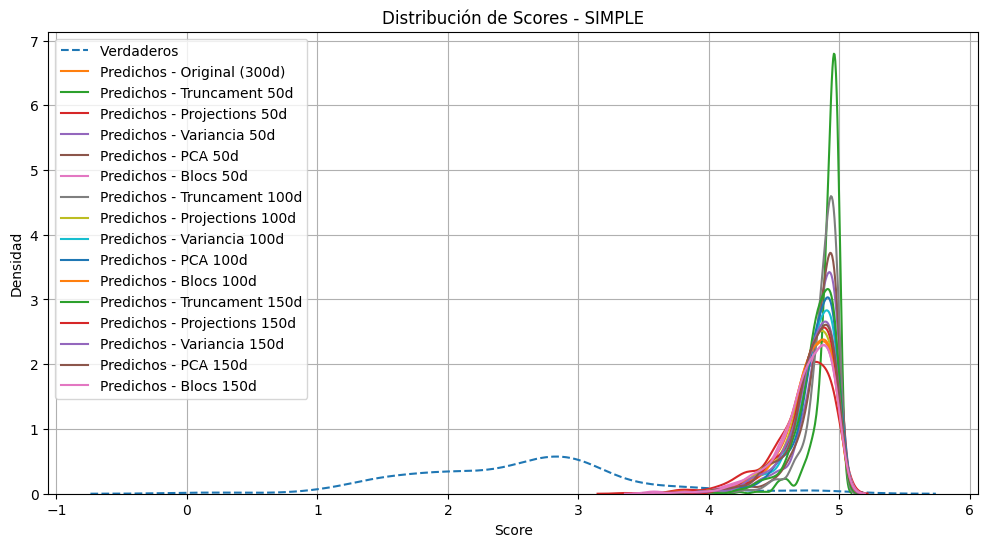

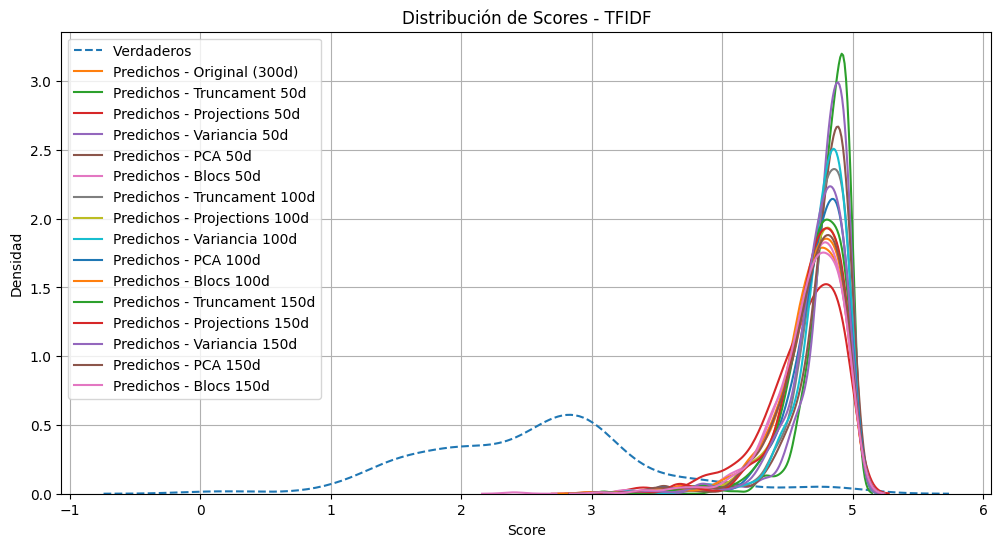

In [111]:
# 2. Gráficos de distribución para modelos seleccionados
selected_models = {
    300: 'Original (300d)',
    '50d_truncament': 'Truncament 50d',
    '50d_projections': 'Projections 50d',
    '50d_variancia': 'Variancia 50d',
    '50d_pca': 'PCA 50d',
    '50d_blocs': 'Blocs 50d',
    '100d_truncament': 'Truncament 100d',
    '100d_projections': 'Projections 100d',
    '100d_variancia': 'Variancia 100d',
    '100d_pca': 'PCA 100d',
    '100d_blocs': 'Blocs 100d',
    '150d_truncament': 'Truncament 150d',
    '150d_projections': 'Projections 150d',
    '150d_variancia': 'Variancia 150d',
    '150d_pca': 'PCA 150d',
    '150d_blocs': 'Blocs 150d'
}

for vec_type in ['simple', 'tfidf']:
    plt.figure(figsize=(12, 6))
    
    for model_name, display_name in selected_models.items():
        # Obtener datos
        true_scores = baseline_results[model_name][vec_type]['true_scores']
        pred_scores = baseline_results[model_name][vec_type]['predicted_scores']
        
        # Gráfico de densidad
        if model_name == 300:
            sns.kdeplot(true_scores, label=f'Verdaderos ', linestyle="--")
        sns.kdeplot(pred_scores, label=f'Predichos - {display_name}', linestyle='-')
    
    plt.title(f'Distribución de Scores - {vec_type.upper()}')
    plt.xlabel('Score')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()

## 8. Modelos de regresión

In [14]:
# ========================================================
# MODELOS DE REGRESIÓN
# ========================================================

def build_cosine_similarity_model(embedding_size: int = 300, learning_rate: float = 0.001):
    """
    Modelo de similitud coseno (Modelo 1 - Embeddings agregados)
    """
    # Input layers
    input_1 = tf.keras.Input(shape=(embedding_size,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_size,), name="input_vector_2")

    # Proyección con activación tanh y dropout
    projection_layer = layers.Dense(
        embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    
    dropout = layers.Dropout(0.3, name="projection_dropout")
    
    # Aplicar proyección y dropout
    projected_1 = dropout(projection_layer(input_1))
    projected_2 = dropout(projection_layer(input_2))

    # Normalización L2 usando Lambda layers
    normalized_1 = layers.Lambda(
        lambda x: tf.nn.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1)
    normalized_2 = layers.Lambda(
        lambda x: tf.nn.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2)

    # Calcular similitud coseno
    similarity_sum = layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="similarity_sum"
    )([normalized_1, normalized_2])

    # Escalar de [-1, 1] a [0, 1]
    output = layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling"
    )(similarity_sum)

    # Crear y compilar modelo
    model = Model(inputs=[input_1, input_2], outputs=output, name="cosine_similarity_model")
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )

    return model



print("Modelos de regresión definidos")

Modelos de regresión definidos


## 9. Modelo de secuencias con atención

In [15]:
# ========================================================
# MODELO DE SECUENCIAS (MODELO 2)
# ========================================================

class SimpleAttention(tf.keras.layers.Layer):
    def __init__(self, units: int, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
        self.dropout_s1 = tf.keras.layers.Dropout(0.3)
        self.dropout_s2 = tf.keras.layers.Dropout(0.2)
        self.W_s1 = tf.keras.layers.Dense(units, activation='tanh', use_bias=True, name="attention_transform")
        # Dense layer to compute attention scores (context vector)
        self.W_s2 = tf.keras.layers.Dense(1, use_bias=False, name="attention_scorer")
        self.supports_masking = True  # Declare that this layer supports masking

    def call(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> tf.Tensor:
        # inputs shape: (batch_size, sequence_length, embedding_dim)
        # mask shape: (batch_size, sequence_length) boolean tensor

        # Attention hidden states
        hidden_states = self.dropout_s1(self.W_s1(inputs))

        # Compute attention scores
        scores = self.dropout_s2(self.W_s2(hidden_states))

        if mask is not None:
            # Apply the mask to the scores before softmax
            expanded_mask = tf.expand_dims(tf.cast(mask, dtype=tf.float32), axis=-1)
            # Add a large negative number to masked (padded) scores
            scores += (1.0 - expanded_mask) * -1e9

        # Compute attention weights
        attention_weights = tf.nn.softmax(scores, axis=1)

        # Compute the context vector (weighted sum of input embeddings)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        return context_vector

    def get_config(self) -> dict:
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config

    def compute_mask(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> Optional[tf.Tensor]:
        return None


def build_and_compile_model_2(
        input_length: int = 32,
        dictionary_size: int = 1000,
        embedding_size: int = 300,
        learning_rate: float = 0.001,
        trainable_embedding: bool = False,
        pretrained_weights: Optional[np.ndarray] = None,
        attention_units: int = 4,
) -> tf.keras.Model:
    """Modelo de secuencias con atención (Modelo 2)"""
    input_1 = tf.keras.Input((input_length,), dtype=tf.int32, name="input_1")
    input_2 = tf.keras.Input((input_length,), dtype=tf.int32, name="input_2")

    # Determine effective embedding parameters
    if pretrained_weights is not None:
        effective_dictionary_size = pretrained_weights.shape[0]
        effective_embedding_size = pretrained_weights.shape[1]
        embedding_initializer = tf.keras.initializers.Constant(pretrained_weights)
        is_embedding_trainable = trainable_embedding
        embedding_layer_name = "embedding_pretrained"
    else:
        effective_dictionary_size = dictionary_size
        effective_embedding_size = embedding_size
        embedding_initializer = 'uniform'
        is_embedding_trainable = True
        embedding_layer_name = "embedding"

    # Shared Embedding Layer
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=effective_dictionary_size,
        output_dim=effective_embedding_size,
        input_length=input_length,
        mask_zero=True,
        embeddings_initializer=embedding_initializer,
        trainable=is_embedding_trainable,
        name=embedding_layer_name
    )

    # Apply embedding layer to both inputs
    embedded_1 = embedding_layer(input_1)  # Shape: (batch_size, input_length, effective_embedding_size)
    embedded_2 = embedding_layer(input_2)  # Shape: (batch_size, input_length, effective_embedding_size)

    # Shared Attention Layer
    sentence_attention_layer = SimpleAttention(units=attention_units, name="sentence_attention")
    # Alternativa: sentence_attention_layer = tf.keras.layers.GlobalAveragePooling1D(name="sentence_attention_layer")

    sentence_vector_1 = sentence_attention_layer(embedded_1)
    sentence_vector_2 = sentence_attention_layer(embedded_2)

    # Projection layer
    first_projection_layer = tf.keras.layers.Dense(
        effective_embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    dropout = tf.keras.layers.Dropout(0.2, name="projection_dropout")
    projected_1 = dropout(first_projection_layer(sentence_vector_1))
    projected_2 = dropout(first_projection_layer(sentence_vector_2))

    # Normalize the projected vectors (L2 normalization)
    normalized_1 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1)
    normalized_2 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2)

    # Compute Cosine Similarity
    similarity_score = tf.keras.layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="cosine_similarity"
    )([normalized_1, normalized_2])

    # Scale similarity from [-1, 1] to [0, 1]
    output_layer = tf.keras.layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling"
    )(similarity_score)

    # Define the Keras Model
    model = tf.keras.Model(
        inputs=[input_1, input_2],
        outputs=output_layer,
        name="sequence_similarity_attention_model"
    )

    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae'],
    )

    return model

print("Modelo de secuencias con atención definido")

Modelo de secuencias con atención definido


## 10. Funciones de evaluación y entrenamiento

In [16]:
# ========================================================
# FUNCIONES DE EVALUACIÓN Y ENTRENAMIENTO
# ========================================================

def pair_list_to_x_y_aggregated(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], float]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """Convierte lista de pares agregados a matrices X e Y"""
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.array(_x_1), np.array(_x_2)), np.array(_y, dtype=np.float32) / 5.0

def pair_list_to_x_y_sequences(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], float]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """Convierte lista de pares de secuencias a matrices X e Y"""
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.row_stack(_x_1), np.row_stack(_x_2)), np.array(_y) / 5.0

def evaluate_model_performance(model, x_test, y_test):
    """Evalúa el rendimiento del modelo y calcula métricas"""
    predictions = model.predict([x_test[0], x_test[1]], verbose=0)
    
    # Convertir predicciones y valores reales a escala [0,5]
    predictions_scaled = predictions.flatten() * 5.0
    y_test_scaled = y_test * 5.0
    
    # Calcular métricas
    pearson_corr, p_value = pearsonr(y_test_scaled, predictions_scaled)
    mae = np.mean(np.abs(y_test_scaled - predictions_scaled))
    rmse = np.sqrt(np.mean((y_test_scaled - predictions_scaled)**2))
    
    return {
        'pearson_correlation': pearson_corr,
        'p_value': p_value,
        'mae': mae,
        'rmse': rmse,
        'predictions': predictions_scaled,
        'true_values': y_test_scaled
    }

print("Funciones de evaluación definidas")

Funciones de evaluación definidas


## 11. Entrenamiento de modelos de regresión (Modelos 1)

In [17]:
# ========================================================
# ENTRENAMIENTO DE MODELOS DE REGRESIÓN (MODELO 1)
# ========================================================

# Configuración de entrenamiento
batch_size = 64
num_epochs = 80

print("\n=== ENTRENAMIENTO DE MODELOS DE REGRESIÓN (MODELO 1) ===")
regression_results = {}

for model_name in all_models:  # e.g. "300d_truncament"
    if model_name == 300:
        dim = model_name
        method = "embeddings originals"
    else:
        # Extraer dimensión y método
        dim_str, method = model_name.split('_')
        dim = int(dim_str.replace('d', ''))

    embedding_model = all_models[model_name]
    print(f"\n=== MODELO: {model_name} | DIMENSIÓN: {dim} | MÉTODO: {method} ===")
    
    # Preparar datos para ambas representaciones
    train_simple = map_pairs_aggregated(train_pairs, dictionary=None, tf_idf_model=None, embedding_model=embedding_model)
    val_simple = map_pairs_aggregated(val_pairs, dictionary=None, tf_idf_model=None, embedding_model=embedding_model)
    
    train_tfidf = map_pairs_aggregated(train_pairs, dictionary=diccionario, tf_idf_model=modelo_tfidf, embedding_model=embedding_model)
    val_tfidf = map_pairs_aggregated(val_pairs, dictionary=diccionario, tf_idf_model=modelo_tfidf, embedding_model=embedding_model)

    regression_results[model_name] = {}

    for representation, (train_data, val_data) in [
        ("simple", (train_simple, val_simple)),
        ("tfidf", (train_tfidf, val_tfidf))
    ]:
        print(f"\n--- Representación: {representation.upper()} ---")

        # Convertir a datos de entrada para entrenamiento y validación
        x_train, y_train = pair_list_to_x_y_aggregated(train_data)
        x_val, y_val = pair_list_to_x_y_aggregated(val_data)

        regression_results[model_name][representation] = {}

        # Callbacks para entrenamiento
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
        )
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=0
        )

        # Entrenar modelo coseno
        print("Entrenando modelo coseno...")
        cosine_model = build_cosine_similarity_model(embedding_size=dim, learning_rate=0.001)

        history_cosine = cosine_model.fit(
            [x_train[0], x_train[1]], y_train,
            validation_data=([x_val[0], x_val[1]], y_val),
            epochs=num_epochs, batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr], verbose=0
        )

        cosine_performance = evaluate_model_performance(cosine_model, x_val, y_val)
        print(f"  Coseno - Pearson: {cosine_performance['pearson_correlation']:.4f}")

        regression_results[model_name][representation]['cosine'] = {
            'model': cosine_model,
            'history': history_cosine,
            'performance': cosine_performance
        }

print("\nModelos de regresión (Modelo 1) entrenados")


=== ENTRENAMIENTO DE MODELOS DE REGRESIÓN (MODELO 1) ===

=== MODELO: 300 | DIMENSIÓN: 300 | MÉTODO: embeddings originals ===

--- Representación: SIMPLE ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.3757

--- Representación: TFIDF ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.4037

=== MODELO: 50d_truncament | DIMENSIÓN: 50 | MÉTODO: truncament ===

--- Representación: SIMPLE ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.3225

--- Representación: TFIDF ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.3712

=== MODELO: 50d_projections | DIMENSIÓN: 50 | MÉTODO: projections ===

--- Representación: SIMPLE ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.3125

--- Representación: TFIDF ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.3429

=== MODELO: 50d_variancia | DIMENSIÓN: 50 | MÉTODO: variancia ===

--- Representación: SIMPLE ---
Entrenando modelo coseno...
  Coseno - Pearson: 0.2773

--- Representación: TFIDF ---
Entrenando modelo coseno...
 

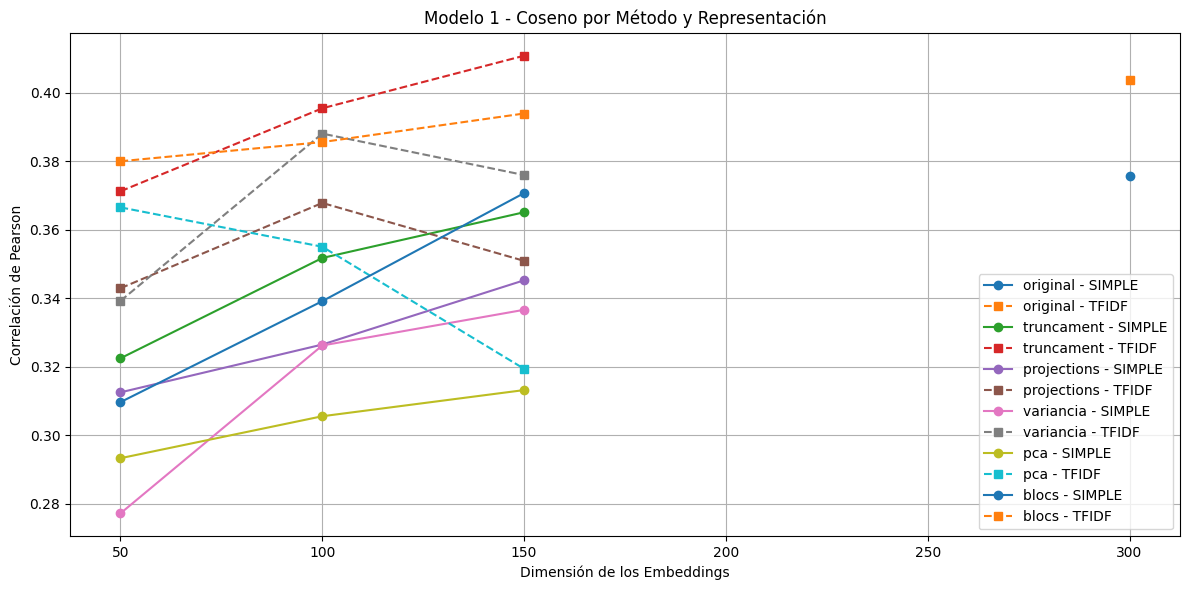

In [18]:
import matplotlib.pyplot as plt

# Crear diccionario para agrupar resultados
results_by_method = {}

for key, values in regression_results.items():
    try:
        if isinstance(key, int) or key.isdigit():
            dim = int(key)
            method = 'original'  # O usa 'base', 'predef', etc.
        else:
            dim_str, method = key.split('d_')  # separa "300d_truncament"
            dim = int(dim_str)
    except Exception as e:
        print(f"Error procesando la clave '{key}': {e}")
        continue

    for vec_type in ['simple', 'tfidf']:
        pearson = values[vec_type]['cosine']['performance']['pearson_correlation']
        results_by_method.setdefault((method, vec_type), []).append((dim, pearson))

# Dibujar
plt.figure(figsize=(12, 6))

for (method, vec_type), dim_corrs in results_by_method.items():
    dim_corrs_sorted = sorted(dim_corrs, key=lambda x: x[0])  # Ordenar por dimensión
    dims = [d for d, _ in dim_corrs_sorted]
    corrs = [c for _, c in dim_corrs_sorted]
    label = f"{method} - {vec_type.upper()}"
    linestyle = '-' if vec_type == 'simple' else '--'
    marker = 'o' if vec_type == 'simple' else 's'
    plt.plot(dims, corrs, label=label, linestyle=linestyle, marker=marker)

# Estética
plt.xlabel('Dimensión de los Embeddings')
plt.ylabel('Correlación de Pearson')
plt.title('Modelo 1 - Coseno por Método y Representación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


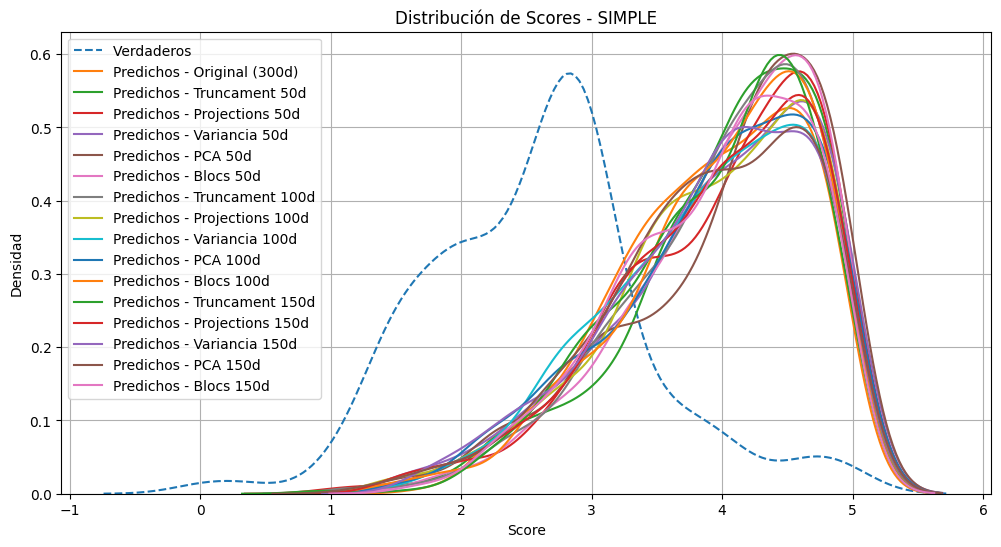

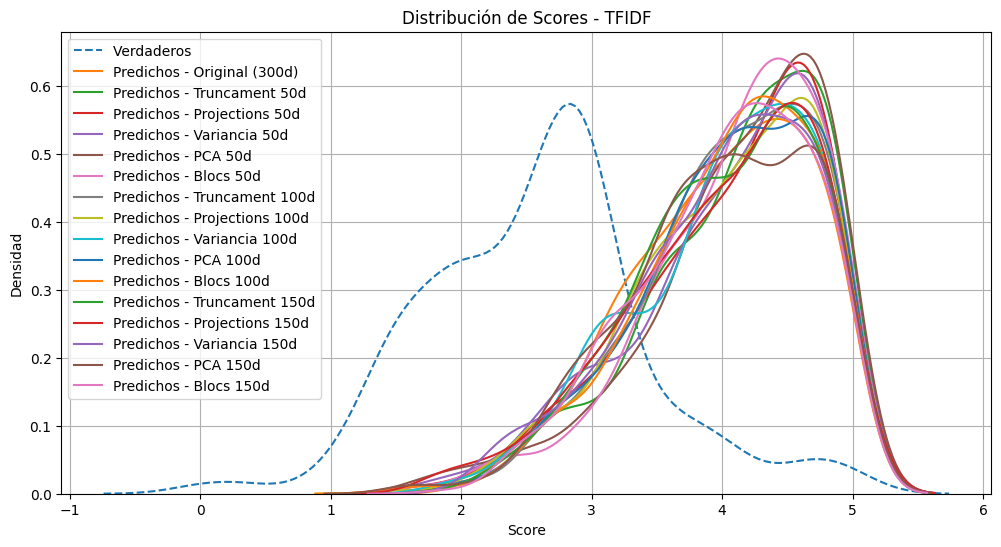

In [110]:
# 2. Gráficos de distribución para modelos seleccionados
selected_models = {
    300: 'Original (300d)',
    '50d_truncament': 'Truncament 50d',
    '50d_projections': 'Projections 50d',
    '50d_variancia': 'Variancia 50d',
    '50d_pca': 'PCA 50d',
    '50d_blocs': 'Blocs 50d',
    '100d_truncament': 'Truncament 100d',
    '100d_projections': 'Projections 100d',
    '100d_variancia': 'Variancia 100d',
    '100d_pca': 'PCA 100d',
    '100d_blocs': 'Blocs 100d',
    '150d_truncament': 'Truncament 150d',
    '150d_projections': 'Projections 150d',
    '150d_variancia': 'Variancia 150d',
    '150d_pca': 'PCA 150d',
    '150d_blocs': 'Blocs 150d'
}

for vec_type in ['simple', 'tfidf']:
    plt.figure(figsize=(12, 6))
    
    for model_name, display_name in selected_models.items():
        # Obtener datos
        true_scores = regression_results[model_name][vec_type]['cosine']['performance']['true_values']
        pred_scores = regression_results[model_name][vec_type]['cosine']['performance']['predictions']
        
        # Gráfico de densidad
        if model_name == 300:
            sns.kdeplot(true_scores, label=f'Verdaderos ', linestyle="--")
        sns.kdeplot(pred_scores, label=f'Predichos - {display_name}', linestyle='-')
    
    plt.title(f'Distribución de Scores - {vec_type.upper()}')
    plt.xlabel('Score')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)

## 12. Entrenamiento del modelo de secuencias (Modelo 2)

In [20]:
# ========================================================
# ENTRENAMIENTO DE MODELOS DE SECUENCIAS PARA TODOS LOS EMBEDDINGS
# ========================================================

print("\n=== ENTRENAMIENTO DEL MODELO DE SECUENCIAS (MODELO 2) PARA TODOS LOS EMBEDDINGS ===")

sequence_results_all = {}

for key, embedding_model in all_models.items():
    print(f"\n### Entrenando para embeddings: {key} (dim {embedding_model.vector_size}) ###")

    # Mapear datos para el modelo de secuencias
    mapped_sequences_train = map_pairs_sequences(
        train_pairs, sequence_len=SEQUENCE_LENGTH, 
        fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None
    )

    mapped_sequences_val = map_pairs_sequences(
        val_pairs, sequence_len=SEQUENCE_LENGTH, 
        fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None
    )

    x_train_seq, y_train_seq = pair_list_to_x_y_sequences(mapped_sequences_train)
    x_val_seq, y_val_seq = pair_list_to_x_y_sequences(mapped_sequences_val)

    print(f"  Formas de datos de secuencias:")
    print(f"    x_train_seq: {x_train_seq[0].shape}, {x_train_seq[1].shape}")
    print(f"    y_train_seq: {y_train_seq.shape}")

    # Preparar pesos pre-entrenados
    pretrained_weights = None
    if USE_PRETRAINED:
        if REMAP_EMBEDDINGS:
            pretrained_weights = np.zeros(
                (len(diccionario.token2id) + 1, embedding_model.vector_size), dtype=np.float32)
            for token, _id in diccionario.token2id.items():
                if token in embedding_model:
                    pretrained_weights[_id + 1] = embedding_model[token]
        else:
            pretrained_weights = np.zeros(
                (embedding_model.vectors.shape[0] + 1, embedding_model.vector_size), dtype=np.float32)
            pretrained_weights[1:, :] = embedding_model.vectors

        print(f"  Pesos pre-entrenados creados: {pretrained_weights.shape}")

    # Preparar datasets
    train_dataset_seq = tf.data.Dataset.from_tensor_slices((x_train_seq, y_train_seq))
    train_dataset_seq = train_dataset_seq.shuffle(buffer_size=len(x_train_seq)).batch(batch_size)

    val_dataset_seq = tf.data.Dataset.from_tensor_slices((x_val_seq, y_val_seq))
    val_dataset_seq = val_dataset_seq.batch(batch_size)

    # Inicializar resultados por embedding
    sequence_results_all[key] = {}

    # Configuraciones de entrenamiento
    configs = [
        {'name': 'pretrained_frozen', 'trainable': False, 'use_pretrained': True},
        {'name': 'pretrained_trainable', 'trainable': True, 'use_pretrained': True},
        {'name': 'random_init', 'trainable': True, 'use_pretrained': False}
    ]

    for config in configs:
        print(f"\n--- Configuración: {config['name']} ---")

        # Crear el modelo
        if config['use_pretrained'] and pretrained_weights is not None:
            model_seq = build_and_compile_model_2(
                input_length=SEQUENCE_LENGTH,
                dictionary_size=len(diccionario.token2id) + 1,
                embedding_size=embedding_model.vector_size,
                learning_rate=0.001,
                trainable_embedding=config['trainable'],
                pretrained_weights=pretrained_weights,
                attention_units=64
            )
        else:
            model_seq = build_and_compile_model_2(
                input_length=SEQUENCE_LENGTH,
                dictionary_size=len(diccionario.token2id) + 1,
                embedding_size=embedding_model.vector_size,
                learning_rate=0.001,
                trainable_embedding=True,
                pretrained_weights=None,
                attention_units=64
            )

        print(f"  Modelo creado: {model_seq.count_params()} parámetros")

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
        )
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=0
        )

        # Entrenamiento
        print("  Entrenando...")
        history_seq = model_seq.fit(
            train_dataset_seq,
            validation_data=val_dataset_seq,
            epochs=num_epochs,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        # Evaluación
        val_perf = evaluate_model_performance(model_seq, x_val_seq, y_val_seq)
        train_perf = evaluate_model_performance(model_seq, x_train_seq, y_train_seq)

        print(f"    Pearson (validación): {val_perf['pearson_correlation']:.4f}")
        print(f"    Pearson (entrenamiento): {train_perf['pearson_correlation']:.4f}")

        # Guardar resultados
        sequence_results_all[key][config['name']] = {
            'model': model_seq,
            'history': history_seq,
            'val_performance': val_perf,
            'train_performance': train_perf,
            'config': config
        }

print("\n=== Todos los modelos de secuencia entrenados ===")



=== ENTRENAMIENTO DEL MODELO DE SECUENCIAS (MODELO 2) PARA TODOS LOS EMBEDDINGS ===

### Entrenando para embeddings: 300 (dim 300) ###
  Formas de datos de secuencias:
    x_train_seq: (2073, 32), (2073, 32)
    y_train_seq: (2073,)
  Pesos pre-entrenados creados: (10180, 300)

--- Configuración: pretrained_frozen ---
  Modelo creado: 3163628 parámetros
  Entrenando...
    Pearson (validación): 0.3728
    Pearson (entrenamiento): 0.6152

--- Configuración: pretrained_trainable ---
  Modelo creado: 3163628 parámetros
  Entrenando...
    Pearson (validación): 0.3538
    Pearson (entrenamiento): 0.9151

--- Configuración: random_init ---
  Modelo creado: 3163628 parámetros
  Entrenando...
    Pearson (validación): 0.3945
    Pearson (entrenamiento): 0.9038

### Entrenando para embeddings: 50d_truncament (dim 50) ###
  Formas de datos de secuencias:
    x_train_seq: (2073, 32), (2073, 32)
    y_train_seq: (2073,)
  Pesos pre-entrenados creados: (10180, 50)

--- Configuración: pretrained_f

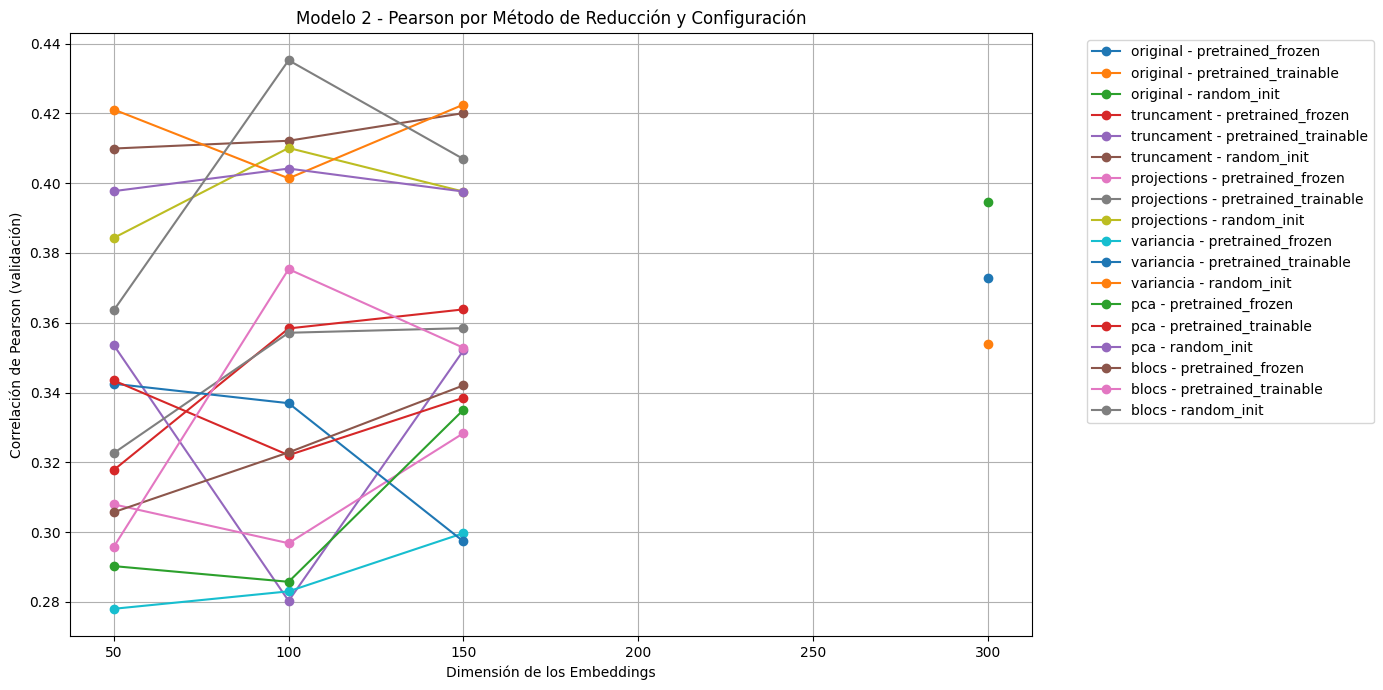

In [106]:
import matplotlib.pyplot as plt

# Agrupar resultados por método (reducción dimensionalidad) y dimensión
results_by_method = {}

for embedding_name, configs in sequence_results_all.items():
    # Extraer dimensión y método
    # Ejemplos embedding_name: 
    # '300' -> dim=300, método='original'
    # '50d_truncament' -> dim=50, método='truncament'
    parts = str(embedding_name).split('d_')
    if len(parts) == 2:
        dim = int(parts[0])
        method = parts[1]
    else:
        # Caso original sin método explícito
        try:
            dim = int(embedding_name)
        except:
            dim = None
        method = 'original'

    for config_name, result in configs.items():
        pearson_val = result['val_performance']['pearson_correlation']
        key = (method, config_name)
        results_by_method.setdefault(key, []).append((dim, pearson_val))

plt.figure(figsize=(14, 7))

for (method, config_name), dim_pearsons in results_by_method.items():
    dim_pearsons_sorted = sorted([dp for dp in dim_pearsons if dp[0] is not None], key=lambda x: x[0])
    dims = [d for d, _ in dim_pearsons_sorted]
    corrs = [c for _, c in dim_pearsons_sorted]
    label = f"{method} - {config_name}"
    plt.plot(dims, corrs, marker='o', label=label)

plt.xlabel('Dimensión de los Embeddings')
plt.ylabel('Correlación de Pearson (validación)')
plt.title('Modelo 2 - Pearson por Método de Reducción y Configuración')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


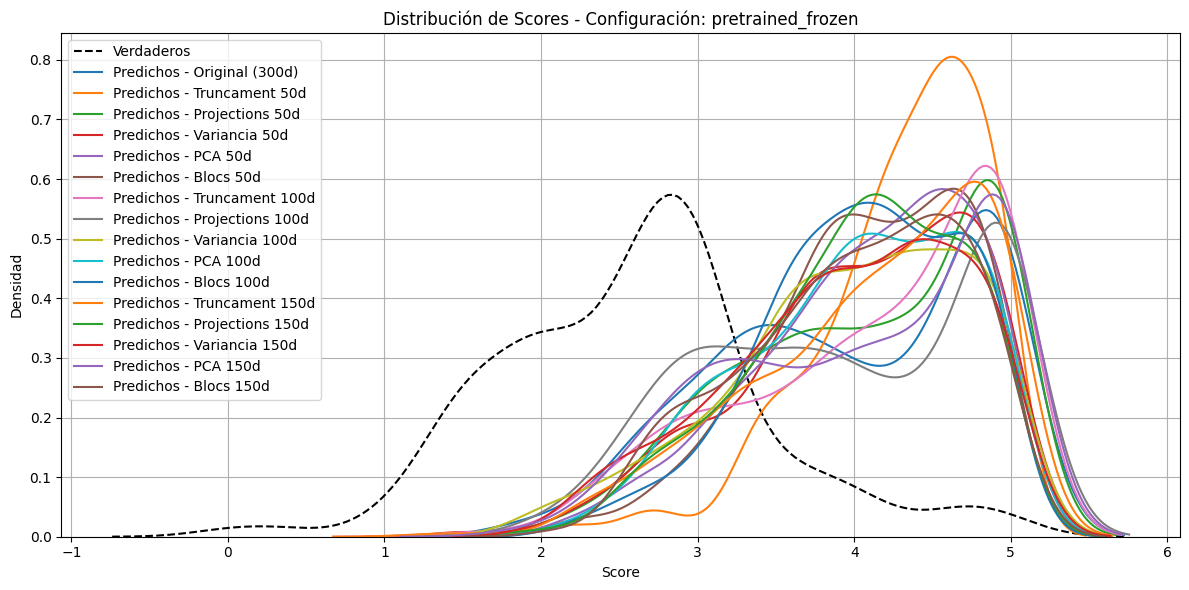

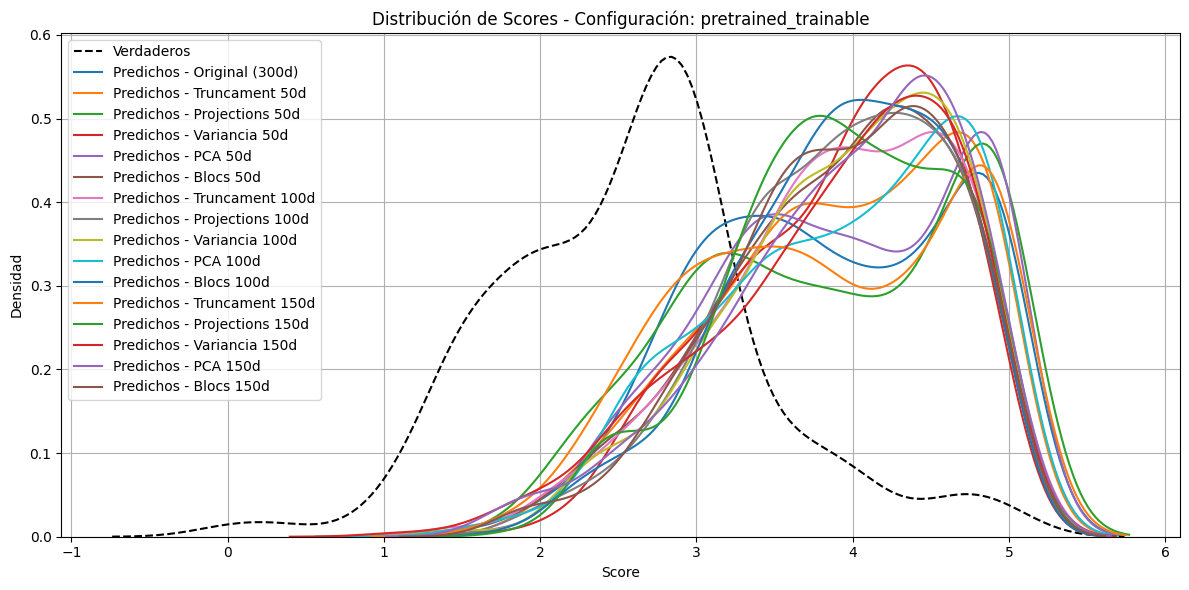

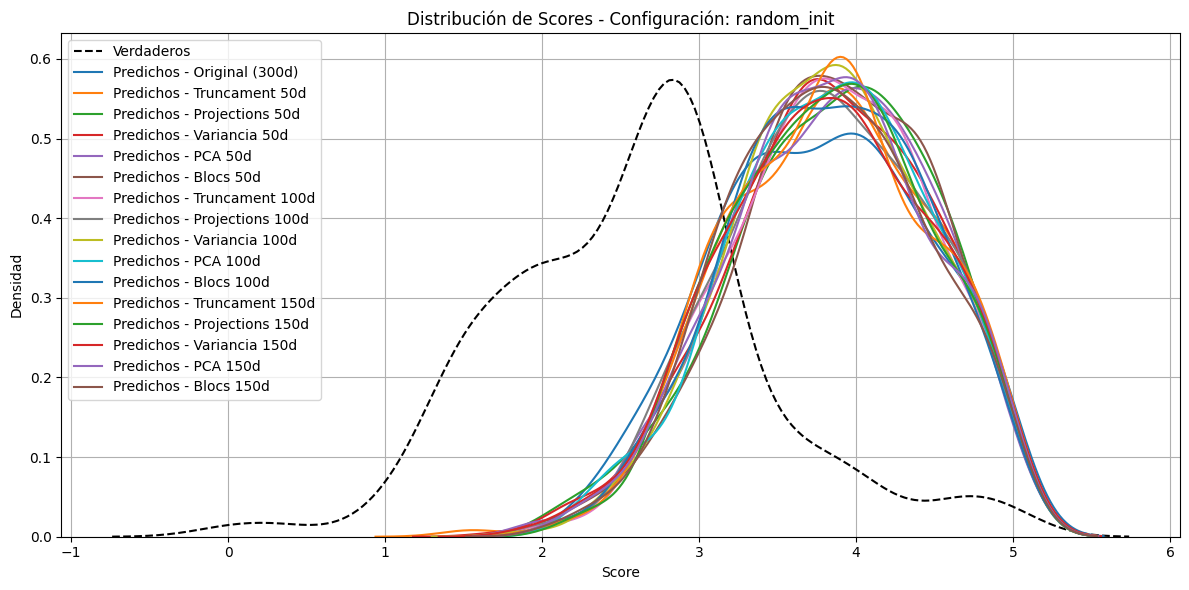

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_models = {
    300: 'Original (300d)',
    '50d_truncament': 'Truncament 50d',
    '50d_projections': 'Projections 50d',
    '50d_variancia': 'Variancia 50d',
    '50d_pca': 'PCA 50d',
    '50d_blocs': 'Blocs 50d',
    '100d_truncament': 'Truncament 100d',
    '100d_projections': 'Projections 100d',
    '100d_variancia': 'Variancia 100d',
    '100d_pca': 'PCA 100d',
    '100d_blocs': 'Blocs 100d',
    '150d_truncament': 'Truncament 150d',
    '150d_projections': 'Projections 150d',
    '150d_variancia': 'Variancia 150d',
    '150d_pca': 'PCA 150d',
    '150d_blocs': 'Blocs 150d'
}


configs_to_plot = ['pretrained_frozen', 'pretrained_trainable', 'random_init']

for config_name in configs_to_plot:
    plt.figure(figsize=(12, 6))
    plt.title(f'Distribución de Scores - Configuración: {config_name}')
    plt.xlabel('Score')
    plt.ylabel('Densidad')
    
    for model_name, display_name in selected_models.items():
        # Acceder a true values y predicciones para el modelo 2
        try:
            true_scores = sequence_results_all[model_name][config_name]['val_performance']['true_values']
            pred_scores = sequence_results_all[model_name][config_name]['val_performance']['predictions']
        except KeyError:
            print(f"Modelo o configuración no encontrados: {model_name}, {config_name}")
            continue
        
        # Graficar solo true_scores una vez (por ejemplo, solo para el modelo original 300)
        if model_name == 300:
            sns.kdeplot(true_scores, label='Verdaderos', linestyle='--', color='black')
        
        sns.kdeplot(pred_scores, label=f'Predichos - {display_name}', linestyle='-')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 13. Análisis y visualización de resultados

In [21]:
# ========================================================
# ANÁLISIS Y VISUALIZACIÓN DE RESULTADOS
# ========================================================

print("\n" + "="*60)
print("ANÁLISIS DE RESULTADOS")
print("="*60)

# Crear tabla de resultados
results_data = []

# Baselines
for dim in baseline_results.keys():
    results_data.append({
        'Modelo': 'Baseline Coseno',
        'Dimensión': dim,
        'Representación': 'Simple',
        'Pearson': baseline_results[dim]['simple'],
        'Tipo': 'Baseline',
        'Configuración': 'N/A'
    })
    results_data.append({
        'Modelo': 'Baseline Coseno',
        'Dimensión': dim,
        'Representación': 'TF-IDF',
        'Pearson': baseline_results[dim]['tfidf'],
        'Tipo': 'Baseline',
        'Configuración': 'N/A'
    })

# Modelos de regresión (Modelo 1)
for dim in regression_results.keys():
    for repr_type in regression_results[dim].keys():
        for model_type in regression_results[dim][repr_type].keys():
            perf = regression_results[dim][repr_type][model_type]['performance']
            results_data.append({
                'Modelo': f'Regresión {model_type.title()}',
                'Dimensión': dim,
                'Representación': repr_type.title(),
                'Pearson': perf['pearson_correlation'],
                'Tipo': 'Regresión (Modelo 1)',
                'Configuración': 'N/A'
            })

# Modelos de secuencias (Modelo 2)
for dim, configs in sequence_results_all.items():
    for config_name, results in configs.items():
        perf = results['val_performance']
        results_data.append({
            'Modelo': 'Secuencias con Atención',
            'Dimensión': dim,
            'Representación': 'Secuencia',
            'Pearson': perf['pearson_correlation'],
            'Tipo': 'Secuencias (Modelo 2)',
            'Configuración': config_name
        })

# Crear DataFrame
df = pd.DataFrame(results_data)

# Mostrar tabla ordenada por correlación
print("\n=== TABLA DE RESULTADOS COMPLETA ===")
df_sorted = df.sort_values('Pearson', ascending=False)
print(df_sorted.round(4).to_string(index=False))

# Encontrar mejor modelo
best_result = df_sorted.iloc[0]
print(f"\n🏆 MEJOR MODELO:")
print(f"   Modelo: {best_result['Modelo']}")
print(f"   Dimensión: {best_result['Dimensión']}")
print(f"   Representación: {best_result['Representación']}")
print(f"   Configuración: {best_result['Configuración']}")
print(f"   Correlación de Pearson: {best_result['Pearson']:.4f}")

# Análisis por tipo de modelo
print(f"\n=== ANÁLISIS POR TIPO DE MODELO ===")
type_analysis = df.groupby('Tipo')['Pearson'].agg(['mean', 'max', 'min', 'std']).round(4)
print(type_analysis)



ANÁLISIS DE RESULTADOS

=== TABLA DE RESULTADOS COMPLETA ===
                 Modelo        Dimensión Representación  Pearson                  Tipo        Configuración
Secuencias con Atención       100d_blocs      Secuencia   0.4352 Secuencias (Modelo 2)          random_init
Secuencias con Atención   150d_variancia      Secuencia   0.4225 Secuencias (Modelo 2)          random_init
Secuencias con Atención    50d_variancia      Secuencia   0.4211 Secuencias (Modelo 2)          random_init
Secuencias con Atención  150d_truncament      Secuencia   0.4201 Secuencias (Modelo 2)          random_init
Secuencias con Atención  100d_truncament      Secuencia   0.4122 Secuencias (Modelo 2)          random_init
       Regresión Cosine  150d_truncament          Tfidf   0.4107  Regresión (Modelo 1)                  N/A
Secuencias con Atención 100d_projections      Secuencia   0.4101 Secuencias (Modelo 2)          random_init
Secuencias con Atención   50d_truncament      Secuencia   0.4099 Secuencia

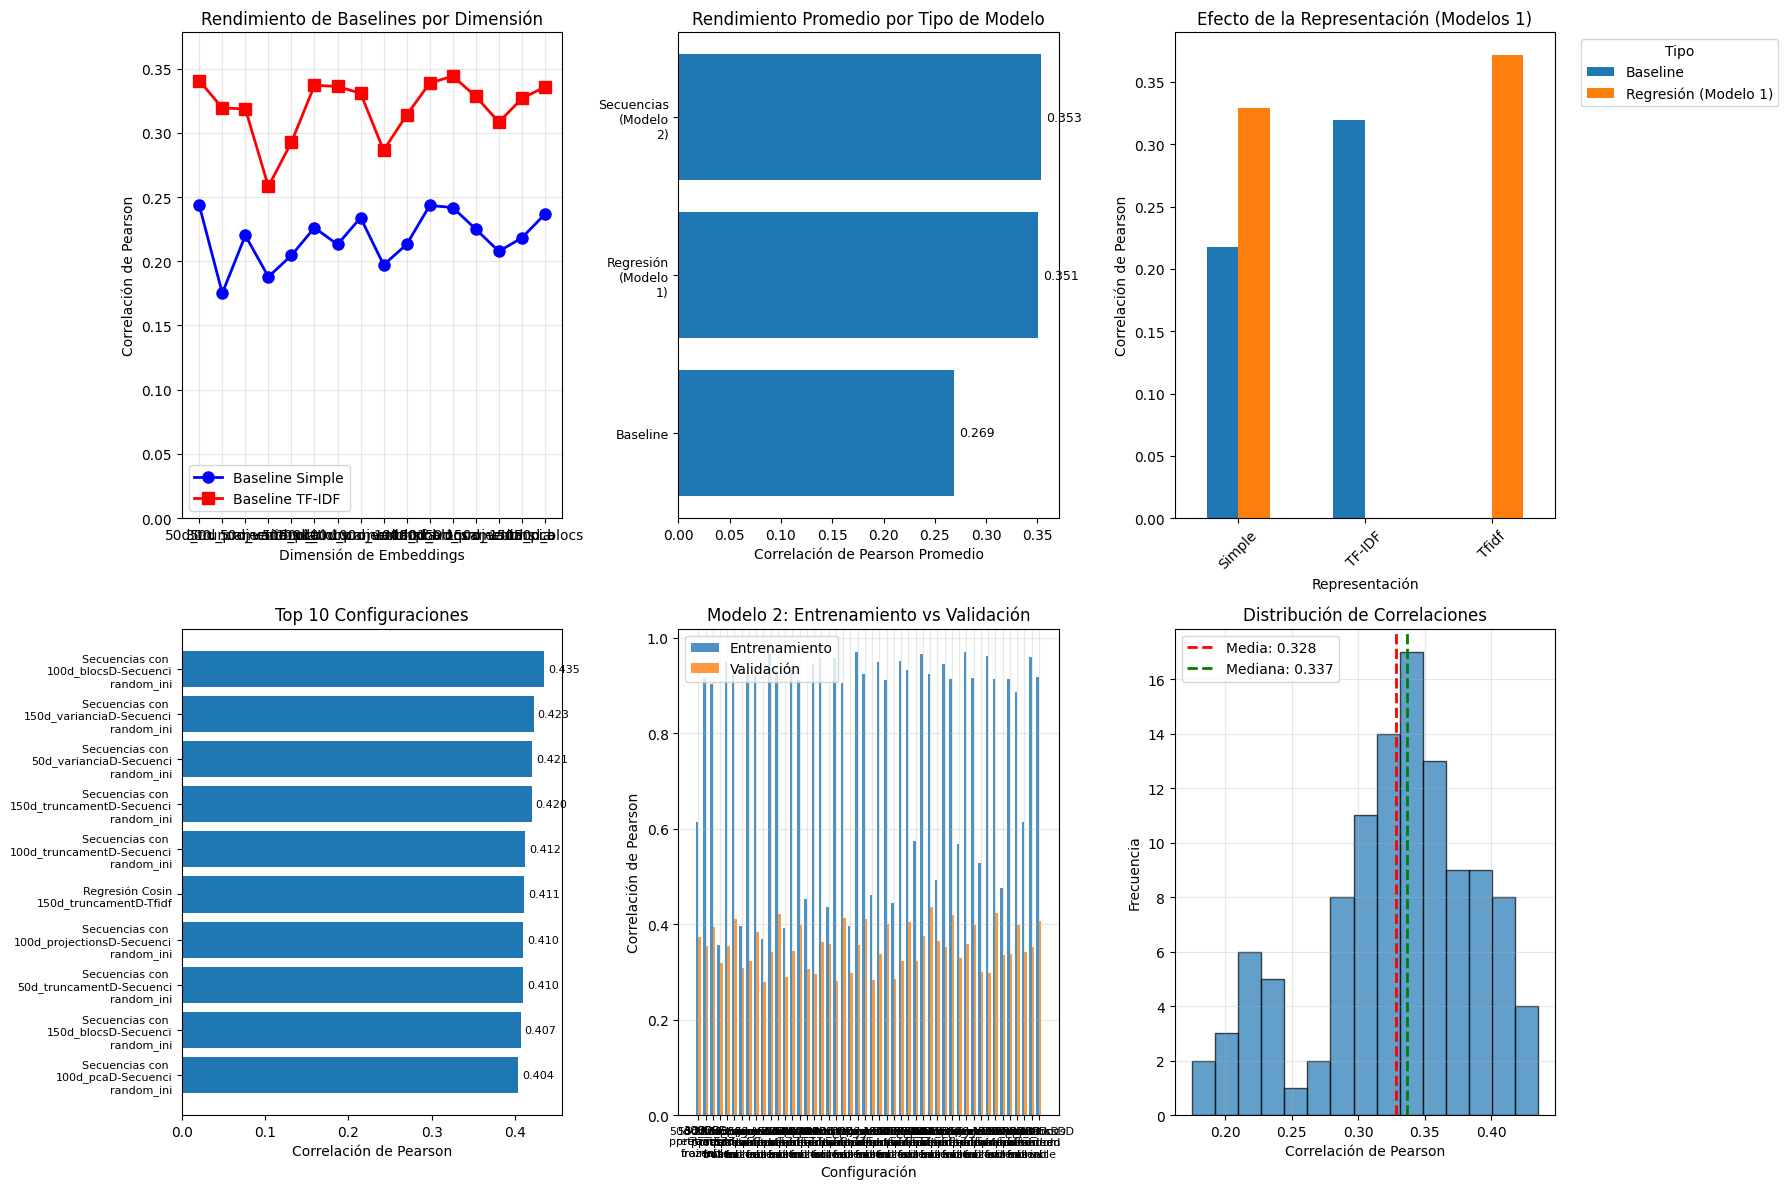

In [23]:
# Visualizaciones
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Correlación de baselines por dimensión
ax1 = axes[0, 0]
baseline_dims = baseline_results.keys()
baseline_simple_vals = [baseline_results[dim]['simple'] for dim in baseline_dims]
baseline_tfidf_vals = [baseline_results[dim]['tfidf'] for dim in baseline_dims]

ax1.plot(baseline_dims, baseline_simple_vals, 'o-', label='Baseline Simple', 
         linewidth=2, markersize=8, color='blue')
ax1.plot(baseline_dims, baseline_tfidf_vals, 's-', label='Baseline TF-IDF', 
         linewidth=2, markersize=8, color='red')
ax1.set_xlabel('Dimensión de Embeddings')
ax1.set_ylabel('Correlación de Pearson')
ax1.set_title('Rendimiento de Baselines por Dimensión')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(baseline_simple_vals + baseline_tfidf_vals) * 1.1)

# 2. Comparación por tipo de modelo
ax2 = axes[0, 1]
type_means = df.groupby('Tipo')['Pearson'].mean().sort_values(ascending=True)
bars = ax2.barh(range(len(type_means)), type_means.values)
ax2.set_yticks(range(len(type_means)))
ax2.set_yticklabels([label.replace(' ', '\n') for label in type_means.index], fontsize=9)
ax2.set_xlabel('Correlación de Pearson Promedio')
ax2.set_title('Rendimiento Promedio por Tipo de Modelo')

# Añadir valores en las barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=9)

# 3. Efecto de la representación (solo Modelo 1)
ax3 = axes[0, 2]
model1_data = df[df['Tipo'].str.contains('Modelo 1|Baseline')].copy()
if not model1_data.empty:
    repr_comparison = model1_data.groupby(['Representación', 'Tipo'])['Pearson'].mean().unstack()
    repr_comparison.plot(kind='bar', ax=ax3, rot=45)
    ax3.set_title('Efecto de la Representación (Modelos 1)')
    ax3.set_ylabel('Correlación de Pearson')
    ax3.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Top 10 configuraciones
ax4 = axes[1, 0]
top_10 = df_sorted.head(10)
labels = []
for _, row in top_10.iterrows():
    label = f"{row['Modelo'][:15]}\n{row['Dimensión']}D-{row['Representación'][:8]}"
    if row['Configuración'] != 'N/A':
        label += f"\n{row['Configuración'][:10]}"
    labels.append(label)

bars = ax4.barh(range(len(top_10)), top_10['Pearson'])
ax4.set_yticks(range(len(top_10)))
ax4.set_yticklabels(labels, fontsize=8)
ax4.set_xlabel('Correlación de Pearson')
ax4.set_title('Top 10 Configuraciones')
ax4.invert_yaxis()

# Añadir valores en las barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=8)

# 5. Comparación Modelo 2 (Secuencias)
ax5 = axes[1, 1]
seq_configs = []
seq_train_scores = []
seq_val_scores = []

for dim, configs in sequence_results_all.items():
    for config_name, results in configs.items():
        config_label = config_name.replace('_', '\n')
        label = f"{dim}D\n{config_label}"
        seq_configs.append(label)
        seq_train_scores.append(results['train_performance']['pearson_correlation'])
        seq_val_scores.append(results['val_performance']['pearson_correlation'])

if seq_configs:
    x_pos = np.arange(len(seq_configs))
    width = 0.35

    ax5.bar(x_pos - width/2, seq_train_scores, width, label='Entrenamiento', alpha=0.8)
    ax5.bar(x_pos + width/2, seq_val_scores, width, label='Validación', alpha=0.8)

    ax5.set_xlabel('Configuración')
    ax5.set_ylabel('Correlación de Pearson')
    ax5.set_title('Modelo 2: Entrenamiento vs Validación')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(seq_configs, fontsize=8)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Distribución de correlaciones
ax6 = axes[1, 2]
ax6.hist(df['Pearson'], bins=15, alpha=0.7, edgecolor='black')
ax6.axvline(df['Pearson'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Media: {df["Pearson"].mean():.3f}')
ax6.axvline(df['Pearson'].median(), color='green', linestyle='--', linewidth=2, 
           label=f'Mediana: {df["Pearson"].median():.3f}')
ax6.set_xlabel('Correlación de Pearson')
ax6.set_ylabel('Frecuencia')
ax6.set_title('Distribución de Correlaciones')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Análisis detallado de mejores modelos
print(f"\n=== ANÁLISIS DETALLADO DE MEJORES MODELOS ===")

# Mejor de cada tipo
best_by_type = df.loc[df.groupby('Tipo')['Pearson'].idxmax()]
print("\nMejor modelo por tipo:")
for _, row in best_by_type.iterrows():
    print(f"  {row['Tipo']}: {row['Pearson']:.4f} ({row['Modelo']} - {row['Dimensión']}D)")

# Análisis de dimensionalidad (solo para Modelo 1)
print(f"\n=== ANÁLISIS DE DIMENSIONALIDAD ===")
model1_dims = df[df['Tipo'].str.contains('Modelo 1|Baseline')].groupby('Dimensión')['Pearson'].agg(['mean', 'max']).round(4)
print("Rendimiento por dimensión (Modelos 1 y Baselines):")
print(model1_dims)

# Mejora respecto al baseline
print(f"\n=== MEJORA RESPECTO AL BASELINE ===")
best_baseline = df[df['Tipo'] == 'Baseline']['Pearson'].max()
best_model1 = df[df['Tipo'] == 'Regresión (Modelo 1)']['Pearson'].max()
best_model2 = df[df['Tipo'] == 'Secuencias (Modelo 2)']['Pearson'].max()

print(f"Mejor Baseline: {best_baseline:.4f}")
print(f"Mejor Modelo 1: {best_model1:.4f} (mejora: {((best_model1/best_baseline-1)*100):+.1f}%)")
print(f"Mejor Modelo 2: {best_model2:.4f} (mejora: {((best_model2/best_baseline-1)*100):+.1f}%)")

# Estadísticas generales
print(f"\n=== ESTADÍSTICAS GENERALES ===")
print(f"Número total de configuraciones evaluadas: {len(df)}")
print(f"Correlación promedio: {df['Pearson'].mean():.4f} ± {df['Pearson'].std():.4f}")
print(f"Rango de correlaciones: [{df['Pearson'].min():.4f}, {df['Pearson'].max():.4f}]")
print(f"Modelos con correlación > 0.5: {(df['Pearson'] > 0.5).sum()}")


=== ANÁLISIS DETALLADO DE MEJORES MODELOS ===

Mejor modelo por tipo:
  Baseline: 0.3441 (Baseline Coseno - 150d_truncamentD)
  Regresión (Modelo 1): 0.4107 (Regresión Cosine - 150d_truncamentD)
  Secuencias (Modelo 2): 0.4352 (Secuencias con Atención - 100d_blocsD)

=== ANÁLISIS DE DIMENSIONALIDAD ===
Rendimiento por dimensión (Modelos 1 y Baselines):
                    mean     max
Dimensión                       
300               0.3409  0.4037
100d_blocs        0.3267  0.3855
100d_pca          0.2969  0.3550
100d_projections  0.3147  0.3678
100d_truncament   0.3241  0.3954
100d_variancia    0.2995  0.3880
150d_blocs        0.3342  0.3939
150d_pca          0.2944  0.3267
150d_projections  0.3123  0.3509
150d_truncament   0.3404  0.4107
150d_variancia    0.3071  0.3759
50d_blocs         0.3132  0.3799
50d_pca           0.2893  0.3665
50d_projections   0.2985  0.3429
50d_truncament    0.2970  0.3712
50d_variancia     0.2656  0.3392

=== MEJORA RESPECTO AL BASELINE ===
Mejor Baselin

## 14. Comparación avanzada One-Hot

In [ ]:
# ========================================================
# EVALUACIÓN CON ONE-HOT
# ========================================================
from gensim import matutils
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

def one_hot_baseline_evaluation(pairs, dictionary):
    true_scores = []
    predicted_scores = []

    print("Avaluant el baseline One-Hot (Bag-of-Words)...")
    for s1_tokens, s2_tokens, score in pairs:
        # Convertim les frases a la seva representació Bag-of-Words (sparse)
        # Això és l'equivalent a un vector One-Hot agregat per recompte de paraules
        bow1 = dictionary.doc2bow(s1_tokens)
        bow2 = dictionary.doc2bow(s2_tokens)
        
        # Si una de les frases no conté paraules del diccionari, la similitud és 0
        if not bow1 or not bow2:
            similarity = 0.0
        else:
            # Calculem la similitud de cosinus per a vectors sparse usant la utilitat de Gensim
            similarity = matutils.cossim(bow1, bow2)
        
        # Gensim cossim retorna valors entre 0 i 1 per a vectors no negatius.
        # Escalem el resultat a l'interval de les etiquetes [0, 5].
        predicted_score = similarity * 5.0
        
        true_scores.append(score)
        predicted_scores.append(predicted_score)

    # Calculem la correlació de Pearson entre les puntuacions reals i les predites
    pearson_corr, p_value = pearsonr(true_scores, predicted_scores)
    
    print("\n--- Resultats del Baseline One-Hot ---")
    print(f"Correlació de Pearson: {pearson_corr:.4f} (p-valor: {p_value:.4f})")
    
    return pearson_corr

# Executem l'avaluació sobre el conjunt de validació utilitzant el diccionari d'entrenament
onehot_corr = one_hot_baseline_evaluation(val_pairs, diccionario)

Avaluant el baseline One-Hot (Bag-of-Words)...

--- Resultats del Baseline One-Hot ---
Correlació de Pearson: 0.3537 (p-valor: 0.0000)


In [54]:
# ========================================================
# COMPARACIÓN FINAL ENTRE MODELOS
# ========================================================
def compare_models(best_model_performance, one_hot_performance):
   
    
    one_hot_mean_score = one_hot_performance

    print("\n=== COMPARACIÓN FINAL ENTRE MEJOR MODELO Y ONE-HOT ===")
    print(f"Mejor modelo (validación): Pearson: {best_model_performance:.4f}")
  
    print(f"One-hot (validación): Pearson: {one_hot_mean_score:.4f}")

    if one_hot_mean_score > best_model_performance:
        print("One-hot supera al mejor modelo basado en embeddings/seqüència")
    else:
        print("El mejor modelo basado en embeddings/seqüència supera a One-hot")

    print("Comparación avanzada completada")

compare_models(0.4352, onehot_corr)


=== COMPARACIÓN FINAL ENTRE MEJOR MODELO Y ONE-HOT ===
Mejor modelo (validación): Pearson: 0.4352
One-hot (validación): Pearson: 0.3537
El mejor modelo basado en embeddings/seqüència supera a One-hot
Comparación avanzada completada
